In [29]:
import random
from typing import TypedDict, List

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END


# === Define state schema ===
class READMEState(TypedDict):
    context: str
    structure: str
    code_files: List[str]
    license_text: str
    required_sections: List[str]
    current_section: str
    completed_sections: List[dict]
    readme: str
    quality_score: float


# === Mocked LLM handler ===
class LLM:
    def invoke(self, messages):
        return HumanMessage(content="[LLM Response]")


llm = LLM()


# === Nodes ===
def orchestrator(state: READMEState):
    return state


def plan_sections(state: READMEState):
    return {"required_sections": ["overview", "installation", "usage"]}


def generate_section(state: READMEState):
    section = state["current_section"]
    return {
        "completed_sections": state.get("completed_sections", []) + [{
            "section": section,
            "content": f"Generated content for {section}"
        }]
    }


def synthesize(state: READMEState):
    parts = [f"## {s['section']}\n{s['content']}" for s in state["completed_sections"]]
    return {"readme": "\n\n".join(parts)}


def evaluate(state: READMEState):
    score = random.uniform(0.6, 1.0)  # simulate evaluation
    return {"quality_score": score}


def optimize(state: READMEState):
    # Enhance content (mocked)
    improved = [{"section": sec["section"], "content": sec["content"] + " [Improved]"} for sec in
                state["completed_sections"]]
    return {"completed_sections": improved}


# === Build Graph ===
graph = StateGraph(READMEState)

# Add nodes
graph.add_node("orchestrator", orchestrator)
graph.add_node("planner", plan_sections)
graph.add_node("worker", generate_section)
graph.add_node("synthesizer", synthesize)
graph.add_node("evaluator", evaluate)
graph.add_node("optimizer", optimize)

# Edges
graph.set_entry_point("orchestrator")
graph.add_edge("orchestrator", "planner")
graph.add_edge("planner", "worker")  # simulate fork (for demo only)
graph.add_edge("worker", "synthesizer")
graph.add_edge("synthesizer", "evaluator")
graph.add_conditional_edges(
    "evaluator",
    lambda state: "optimizer" if state["quality_score"] < 0.8 else END,
    {"optimizer": "optimizer", END: END}
)
graph.add_edge("optimizer", "synthesizer")

# Compile
compiled = graph.compile()

# === Example Invocation ===
state = compiled.invoke({
    "context": "ASE_2024",
    "structure": "project structure tree",
    "code_files": ["def foo(): pass"],
    "license_text": "MIT License",
    "current_section": "overview",
    "completed_sections": [],
    "readme": "",
    "quality_score": 0.0,
    "required_sections": []
})

print("\nFinal README:\n", state.get("readme"))



Final README:
 ## overview
Generated content for overview [Improved]


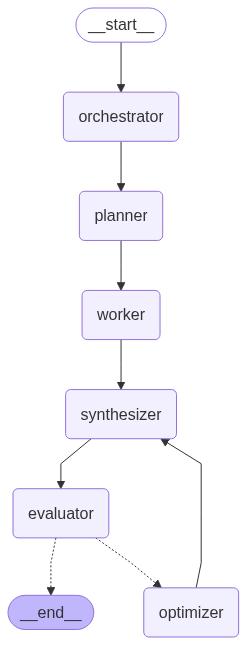

In [30]:
compiled

In [34]:
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
import random

# === Define State ===
class READMEState(TypedDict):
    context: str
    structure: str
    code_files: List[str]
    license_text: str
    required_sections: List[str]
    completed_sections: List[dict]
    current_section: str
    readme: str
    quality_score: float


# === Mock LLM ===
class MockLLM:
    def invoke(self, prompt_or_msgs):
        if isinstance(prompt_or_msgs, list):
            return HumanMessage(content="overview, installation, usage")
        return HumanMessage(content=f"Generated content for {prompt_or_msgs}")

llm = MockLLM()


# === Nodes ===
def load_json():
    return {
        "context": "ASE_2024",
        "structure": "ml-image-classifier repo tree",
        "code_files": ["def foo(): pass"],
        "license_text": "MIT License",
        "completed_sections": [],
        "readme": "",
        "quality_score": 0.0,
        "required_sections": []
    }


def plan_sections(state: READMEState):
    prompt = [
        SystemMessage(content="List the sections that should appear in a README."),
        HumanMessage(content=state["context"])
    ]
    response = llm.invoke(prompt)
    sections = [s.strip() for s in response.content.split(",")]
    return {"required_sections": sections}


def generate_section(state: READMEState):
    section = state["current_section"]
    return {
        "completed_sections": state.get("completed_sections", []) + [{
            "section": section,
            "content": f"Generated content for {section}"
        }]
    }


def assemble_readme(state: READMEState):
    content = [f"## {s['section']}\n{s['content']}" for s in state["completed_sections"]]
    return {"readme": "\n\n".join(content)}


def evaluate_quality(state: READMEState):
    score = random.uniform(0.6, 1.0)  # Simulate quality
    return {"quality_score": score}


def refine_sections(state: READMEState):
    updated = [
        {"section": s["section"], "content": s["content"] + " [Improved]"}
        for s in state["completed_sections"]
    ]
    return {"completed_sections": updated}


# === Build LangGraph ===
graph = StateGraph(READMEState)

# Add nodes
graph.add_node("planner", plan_sections)
graph.add_node("worker", generate_section)
graph.add_node("synthesizer", assemble_readme)
graph.add_node("evaluator", evaluate_quality)
graph.add_node("optimizer", refine_sections)

# Edges
graph.set_entry_point("planner")
graph.add_edge("planner", "worker")  # simulate a fork here (can be looped in executor)
graph.add_edge("worker", "synthesizer")
graph.add_edge("synthesizer", "evaluator")
graph.add_conditional_edges(
    "evaluator",
    lambda state: "optimizer" if state["quality_score"] < 0.8 else END,
    {"optimizer": "optimizer", END: END}
)
graph.add_edge("optimizer", "synthesizer")

compiled = graph.compile()

# === Run Example ===
initial_state = load_json()
initial_state["current_section"] = "overview"
final = compiled.invoke(initial_state)

print("\nREADME Generated:\n")
print(final["readme"])
print("\nQuality Score:", final["quality_score"])
print("Improved?", any("Improved" in s["content"] for s in final["completed_sections"]))



README Generated:

## overview
Generated content for overview

Quality Score: 0.9484095446072422
Improved? False


In [32]:
from langgraph.graph import END, START, StateGraph
from langchain_core.runnables import RunnableLambda
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional, TypedDict

# === State Definition ===
class READMEState(TypedDict):
    artifact_json: dict
    required_sections: List[str]
    section_outputs: List[str]
    final_readme: Optional[str]
    quality_score: Optional[float]


# === Nodes ===
def plan_sections(state: READMEState) -> dict:
    # For now return static list
    return {"required_sections": ["Overview", "Usage", "License"]}

def generate_section(state: READMEState, section: str) -> dict:
    # Dummy content generation
    return {"section_outputs": [f"## {section}\nThis is the generated content for {section}."]}

def assemble_readme(state: READMEState) -> dict:
    merged = "\n\n".join(state.get("section_outputs", []))
    return {"final_readme": merged}

def evaluate_quality(state: READMEState) -> dict:
    # Dummy score for now
    return {"quality_score": 0.6 if "License" in state.get("required_sections", []) else 0.9}

def refine_sections(state: READMEState) -> dict:
    improved = [s + "\n\nImproved." for s in state.get("section_outputs", [])]
    return {"section_outputs": improved}


# === Build Graph ===
graph = StateGraph(READMEState)

# Static entrypoint
graph.add_node("plan_sections", plan_sections)

# Create worker node (shared for dynamic invocation)
worker = RunnableLambda(lambda state: generate_section(state, state["current_section"]))
graph.add_node("generate_section", worker)

graph.add_node("assemble_readme", assemble_readme)
graph.add_node("evaluate_quality", evaluate_quality)
graph.add_node("refine_sections", refine_sections)

# === Workflow ===
graph.set_entry_point("plan_sections")

# Send to dynamic workers using send method
@graph.send
def section_sender(state: READMEState):
    return [
        {"node": "generate_section", "kwargs": {"current_section": section}}
        for section in state["required_sections"]
    ]

graph.add_edge("generate_section", "assemble_readme")
graph.add_edge("assemble_readme", "evaluate_quality")
graph.add_conditional_edges(
    "evaluate_quality",
    lambda state: "refine_sections" if state["quality_score"] < 0.8 else END,
    {
        "refine_sections": "assemble_readme",
        END: END,
    },
)

readme_workflow = graph.compile()

# === Visualize ===
from IPython.display import Image
Image(readme_workflow.get_graph().draw_mermaid_png())

# === Example run ===
example_input = {
    "artifact_json": {},
    "required_sections": [],
    "section_outputs": [],
    "final_readme": None,
    "quality_score": None,
}

result = readme_workflow.invoke(example_input)
print(result["final_readme"])


C:\workplace\AURA\.venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


AttributeError: 'StateGraph' object has no attribute 'send'